In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.0382

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 605ms/step - loss: 0.0315
Average validation loss: 0.6481597423553467
4/4 [==============================] - 6s 620ms/step - loss: 0.0315 - val_loss: 0.6482
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 601ms/step - loss: 0.0277 - val_loss: 0.6482
Average validation loss: 0.49722757935523987
4/4 [==============================] - 8s 613ms/step - loss: 0.0277 - val_loss: 0.5727
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 594ms/step - loss: 0.0215 - val_loss: 0.5727
Average validation loss: 0.2270006537437439
4/4 [==============================] - 11s 606ms/step - loss: 0.0215 - val_los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 538ms/step - loss: 0.0016
Average validation loss: 0.006714472081512213
8/8 [==============================] - 4s 550ms/step - loss: 0.0016 - val_loss: 0.0067
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 9s 542ms/step - loss: 0.0016 - val_loss: 0.0067
Average validation loss: 0.02174529805779457
8/8 [==============================] - 9s 553ms/step - loss: 0.0016 - val_loss: 0.0142
Epoch 3/10
8/8 [==============================] - 13s 548ms/step - loss: 0.0016 - val_loss: 0.0142
Average validation loss: 0.021321267820894718
8/8 [==============================] - 13s 560ms/step - loss: 0.0016 - val_loss: 0.0166
Epoch 4/10
8/8 [==============================] - 18s 545ms/step - loss: 0.0015 - val_loss: 0.0166
Average validation loss: 0.011867966037243605
8/8 [==========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 7s 551ms/step - loss: 0.0021
Average validation loss: 0.11470147597894235
12/12 [==============================] - 7s 562ms/step - loss: 0.0021 - val_loss: 0.1147
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 13s 551ms/step - loss: 0.0021 - val_loss: 0.1147
Average validation loss: 0.07833541547919738
12/12 [==============================] - 14s 561ms/step - loss: 0.0021 - val_loss: 0.0965
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 20s 548ms/step - loss: 0.0021 - val_loss: 0.0965
Average validation loss: 0.05139506235718727
12/12 [==============================] - 20s 559ms/step - loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 9s 547ms/step - loss: 0.0022
Average validation loss: 0.06951584627677221
16/16 [==============================] - 9s 555ms/step - loss: 0.0022 - val_loss: 0.0695
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 18s 553ms/step - loss: 0.0021 - val_loss: 0.0695
Average validation loss: 0.059099249250721186
16/16 [==============================] - 18s 563ms/step - loss: 0.0021 - val_loss: 0.0643
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 27s 545ms/step - loss: 0.0021 - val_loss: 0.0643
Average validation loss: 0.04215708188712597
16/16 [==============================] - 27s 554ms/step - los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 11s 550ms/step - loss: 0.0019
Average validation loss: 0.2054266154766083
20/20 [==============================] - 11s 560ms/step - loss: 0.0019 - val_loss: 0.2054
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 22s 548ms/step - loss: 0.0017 - val_loss: 0.2054
Average validation loss: 0.04487707950174809
20/20 [==============================] - 22s 557ms/step - loss: 0.0017 - val_loss: 0.1252
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 33s 551ms/step - loss: 0.0017 - val_loss: 0.1252
Average validation loss: 0.07301693558692932
20/20 [==============================] - 34s 561ms/step - los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 13s 556ms/step - loss: 0.0011
Average validation loss: 0.09746800487240155
24/24 [==============================] - 14s 565ms/step - loss: 0.0011 - val_loss: 0.0975
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 27s 549ms/step - loss: 0.0011 - val_loss: 0.0975
Average validation loss: 0.05811656514803568
24/24 [==============================] - 27s 559ms/step - loss: 0.0011 - val_loss: 0.0778
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 40s 551ms/step - loss: 0.0011 - val_loss: 0.0778
Average validation loss: 0.07305167118708293
24/24 [==============================] - 41s 562ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 22s 553ms/step - loss: 0.0014
Average validation loss: 0.15455059185624123
40/40 [==============================] - 23s 563ms/step - loss: 0.0014 - val_loss: 0.1546
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 45s 553ms/step - loss: 0.0013 - val_loss: 0.1546
Average validation loss: 0.1100127212703228
40/40 [==============================] - 45s 563ms/step - loss: 0.0013 - val_loss: 0.1323
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 67s 552ms/step - loss: 0.0013 - val_loss: 0.1323
Average validation loss: 0.09913865216076374
40/40 [==============================] - 68s 562ms/step - los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 26s 545ms/step - loss: 0.0011
Average validation loss: 0.08309295892346806
48/48 [==============================] - 27s 555ms/step - loss: 0.0011 - val_loss: 0.0831
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 53s 549ms/step - loss: 0.0010 - val_loss: 0.0831
Average validation loss: 0.10561208275612444
48/48 [==============================] - 53s 558ms/step - loss: 0.0010 - val_loss: 0.0944
Epoch 3/10
48/48 [==============================] - 80s 550ms/step - loss: 9.8211e-04 - val_loss: 0.0944
Average validation loss: 0.1278587874645988
48/48 [==============================] - 80s 559ms/step - loss: 9.8211e-04 - val_loss: 0.1055
Epoch 4/10
48/48 [==============================] - 106s 546ms/step - loss: 9.4902e-04 - val_loss: 0.1055
Average validation loss: 0.103235

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 31s 550ms/step - loss: 0.0012
Average validation loss: 0.11600123408113307
56/56 [==============================] - 31s 559ms/step - loss: 0.0012 - val_loss: 0.1160
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 62s 552ms/step - loss: 9.8672e-04 - val_loss: 0.1160
Average validation loss: 0.36510389254981745
56/56 [==============================] - 63s 561ms/step - loss: 9.8672e-04 - val_loss: 0.2406
Epoch 3/10
56/56 [==============================] - 94s 554ms/step - loss: 8.9497e-04 - val_loss: 0.2406
Average validation loss: 0.1286849808779412
56/56 [==============================] - 94s 563ms/step - loss: 8.9497e-04 - val_loss: 0.2033
Epoch 4/10
56/56 [==============================] - 125s 554ms/step - loss: 8.3922e-04 - val_loss: 0.2033
Average validation loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 35s 550ms/step - loss: 9.1342e-04
Average validation loss: 0.08475083789322113
64/64 [==============================] - 36s 560ms/step - loss: 9.1342e-04 - val_loss: 0.0848
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 71s 552ms/step - loss: 7.5631e-04 - val_loss: 0.0848
Average validation loss: 0.18125730370500293
64/64 [==============================] - 72s 561ms/step - loss: 7.5631e-04 - val_loss: 0.1330
Epoch 3/10
64/64 [==============================] - 107s 552ms/step - loss: 6.6421e-04 - val_loss: 0.1330
Average validation loss: 0.07963047486464347
64/64 [==============================] - 108s 562ms/step - loss: 6.6421e-04 - val_loss: 0.1152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 40s 553ms/step - loss: 7.5831e-04
Average validation loss: 0.08056458292735948
72/72 [==============================] - 40s 562ms/step - loss: 7.5831e-04 - val_loss: 0.0806
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 80s 553ms/step - loss: 6.7797e-04 - val_loss: 0.0806
Average validation loss: 0.06148626200026936
72/72 [==============================] - 81s 562ms/step - loss: 6.7797e-04 - val_loss: 0.0710
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 120s 547ms/step - loss: 6.0830e-04 - val_loss: 0.0710
Average validation loss: 0.12197175704770619
72/72 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 44s 545ms/step - loss: 6.8641e-04
Average validation loss: 0.05674987323582172
80/80 [==============================] - 44s 554ms/step - loss: 6.8641e-04 - val_loss: 0.0567
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 88s 547ms/step - loss: 5.8064e-04 - val_loss: 0.0567
Average validation loss: 0.07798495646566153
80/80 [==============================] - 89s 556ms/step - loss: 5.8064e-04 - val_loss: 0.0674
Epoch 3/10
80/80 [==============================] - 133s 546ms/step - loss: 5.2541e-04 - val_loss: 0.0674
Average validation loss: 0.09052026085555553
80/80 [==============================] - 133s 555ms/step - loss: 5.2541e-04 - val_loss: 0.0751
Epoch 4/10
80/80 [==============================] - 177s 550ms/step - loss: 4.8860e-04 - val_loss: 0.0751
Average valid

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 53s 549ms/step - loss: 0.0010
Average validation loss: 0.11109105206879007
96/96 [==============================] - 54s 558ms/step - loss: 0.0010 - val_loss: 0.1111
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 106s 551ms/step - loss: 8.1229e-04 - val_loss: 0.1111
Average validation loss: 0.10346399950482876
96/96 [==============================] - 107s 560ms/step - loss: 8.1229e-04 - val_loss: 0.1073
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 160s 546ms/step - loss: 7.0304e-04 - val_loss: 0.1073
Average validation loss: 0.16485854685045828
96/96 [==============================] - 16

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 66s 547ms/step - loss: 7.3179e-04
Average validation loss: 0.05339961304715644
120/120 [==============================] - 67s 557ms/step - loss: 7.3179e-04 - val_loss: 0.0534
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 132s 546ms/step - loss: 6.1056e-04 - val_loss: 0.0534
Average validation loss: 0.052010163106285034
120/120 [==============================] - 133s 555ms/step - loss: 6.1056e-04 - val_loss: 0.0527
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 199s 546ms/step - loss: 5.6234e-04 - val_loss: 0.0527
Average validation loss: 0.06907819983527665
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 79s 551ms/step - loss: 7.0064e-04
Average validation loss: 0.26135237763325375
144/144 [==============================] - 81s 560ms/step - loss: 7.0064e-04 - val_loss: 0.2614
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 160s 549ms/step - loss: 5.9807e-04 - val_loss: 0.2614
Average validation loss: 0.119060927329378
144/144 [==============================] - 161s 558ms/step - loss: 5.9807e-04 - val_loss: 0.1902
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 240s 546ms/step - loss: 5.1560e-04 - val_loss: 0.1902
Average validation loss: 0.057665432336231476
144/144 [=================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 88s 548ms/step - loss: 4.8034e-04
Average validation loss: 0.08960714754648506
160/160 [==============================] - 89s 557ms/step - loss: 4.8034e-04 - val_loss: 0.0896
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 177s 549ms/step - loss: 4.0667e-04 - val_loss: 0.0896
Average validation loss: 0.04382755816914141
160/160 [==============================] - 178s 558ms/step - loss: 4.0667e-04 - val_loss: 0.0667
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 266s 546ms/step - loss: 3.7070e-04 - val_loss: 0.0667
Average validation loss: 0.06606289234478027
160/160 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 110s 550ms/step - loss: 8.0136e-04
Average validation loss: 0.0976015905663371
200/200 [==============================] - 112s 559ms/step - loss: 8.0136e-04 - val_loss: 0.0976
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 221s 547ms/step - loss: 6.9222e-04 - val_loss: 0.0976
Average validation loss: 0.1040075296163559
200/200 [==============================] - 223s 556ms/step - loss: 6.9222e-04 - val_loss: 0.1008
Epoch 3/10
200/200 [==============================] - 332s 546ms/step - loss: 6.0633e-04 - val_loss: 0.1008
Average validation loss: 0.09397685132920743
200/200 [==============================] - 334s 555ms/step - loss: 6.0633e-04 - val_loss: 0.0985
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_se

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:07 - loss: 1.3613e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 132s 548ms/step - loss: 5.5116e-04
Average validation loss: 0.06174228079617024
240/240 [==============================] - 134s 557ms/step - loss: 5.5116e-04 - val_loss: 0.0617
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 266s 549ms/step - loss: 4.5505e-04 - val_loss: 0.0617
Average validation loss: 0.09787045371298717
240/240 [==============================] - 268s 558ms/step - loss: 4.5505e-04 - val_loss: 0.0798
Epoch 3/10
240/240 [==============================] - 400s 550ms/step - loss: 3.8824e-04 - val_loss: 0.0798
Average validation loss: 0.11027993706890248
240/240 [==============================] - 402s 559ms/step - loss: 3.8824e-04 - val_loss: 0.0900
Epoch 4/10
240/240 [==============================] - 533s 547ms/step - loss: 3.4923e-04 - val_loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.0612006251165735, 0.0768655085998624, 0.11537476048114133, 0.09442568118923418, 0.14302613603719513, 0.07058088861396604, 0.1073335152628863, 0.1213517010958943, 0.13405603419042744, 0.09468825255002634, 0.10216745616034215, 0.08607500571022106, 0.09333564057546112, 0.05992810355692832, 0.06425546427524345, 0.0614765018851207, 0.061979590875889105, 0.06902896379003373]
std_val_losses =  [0.11863745450294144, 0.06623192236303116, 0.07806620474801383, 0.06643306255467024, 0.1625941704634141, 0.025065946526374932, 0.035690762856809465, 0.03987724657880075, 0.06228504494160312, 0.03440499475194009, 0.03400765905135329, 0.02959225921443293, 0.04380494631406306, 0.03135298182956509, 0.035374858264566565, 0.018877223112421484, 0.022187023226753682, 0.02571363184332848]


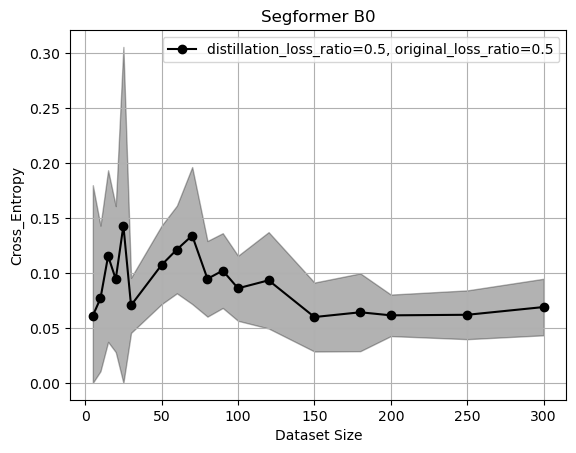

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()